# Исследование юнит-экономики мобильной игры

## Общая задача:  
Провести расчёт и анализ ключевых метрик: LTV, CAC, ROI, ARPPU и Retention Rate — и составить заключение о текущем состоянии юнит-экономики приложения.

В рамках решения этой задачи вы подготовите данные, проведёте когортный анализ ключевых финансовых метрик и оцените окупаемость.  

## Проект состоит из шести частей:

Часть 1. Подготовка данных.
Часть 2. Когортный анализ LTV.
Часть 3. Расчёт CAC.
Часть 4. Расчёт Payback Period.
Часть 5. Расчёт ROI.
Часть 6. Расчёт ARPPU и Retention Rate.

## Описание данных

В вашем распоряжении четыре таблицы с данными:

**`тут_была_ссылка`** — информация о пользователях.

`device_id` — уникальный ID устройства.

`install_time` — дата и время установки игры.

`country_code` — код страны (например, RU, AZ).

`traffic_type` — тип трафика (paid,organic).

`platform` — ОС устройства (ios, android).

`source` — источник привлечения.

`campaign`— название рекламной кампании.

`user_id` — уникальный ID пользователя.

**`тут_была_ссылка`** — события пользователей в игре.

device_id — ID устройства.
session_id — ID сессии.
time — дата и время события.
event_name — событие запуска игры.

**`тут_была_ссылка`** — данные о транзакциях пользователей.

`device_id` — уникальный идентификатор устройства.

`session_id` — идентификатор игровой сессии.

`transaction_id` — уникальный ID транзакции.

`time` — дата и время покупки.

`payment_type` — способ оплаты (bank_card, paypal, game_wallet).

`item_name` — название товара (например, chest_1, coin_pack_2).

`price` — стоимость товара.

`status` — статус транзакции (success, failed).

**`тут_была_ссылка`** — затраты на маркетинг по месяцам и каналам.

`month` — месяц в формате YYYY-MM.

`source` — рекламный источник (например, google, yandex, youtube).

`traffic_type` — тип трафика (paid, organic, referral).

`marketing_costs` — затраты на маркетинг.

## Проект. Часть 1. Подготовка данных

### Загрузка данных

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

In [2]:
df_users = pd.read_csv('тут_была_ссылка')
df_events = pd.read_csv('тут_была_ссылка')
df_transactions = pd.read_csv('тут_была_ссылка')
df_marketing_costs = pd.read_csv('тут_была_ссылка')

In [3]:
display(df_users.head())
display(df_events.head())
display(df_transactions.head())

# Выводим на экран размер исходных таблиц
print(df_users.shape, df_events.shape, df_transactions.shape)

,device_id,install_time,country_code,traffic_type,platform,source,campaign,user_id
0,bd8faa44-01d5-4fac-8e58-102ef16d72b6,2024-01-23 13:09:52,AZ,paid,ios,youtube,yt2,1.0
1,788cdde7-aa57-41f1-ac42-402ed9fa1b47,2024-01-05 18:21:35,RU,organic,ios,direct_app_download,NaN,3.0
2,f1842785-15e9-4fda-9b2d-5ffdcceae78b,2024-01-02 10:42:57,RU,paid,android,google,g2,4.0
3,26f430d8-841c-4944-9f6d-2262a1d64787,2024-01-02 21:59:31,RU,organic,ios,direct_app_download,NaN,5.0
4,ace4f666-c8ac-45b7-a0c1-e9f3dad48ab1,2024-01-21 19:29:42,BY,organic,ios,direct_app_download,NaN,NaN


,device_id,session_id,time,event_name
0,ebd6c0a6-5a0a-4ea4-8f36-48771c983b1a,1,2024-01-01,app_start
1,ebd6c0a6-5a0a-4ea4-8f36-48771c983b1a,2,2024-01-02,app_start
2,ebd6c0a6-5a0a-4ea4-8f36-48771c983b1a,3,2024-01-02,app_start
3,ebd6c0a6-5a0a-4ea4-8f36-48771c983b1a,4,2024-01-04,app_start
4,ebd6c0a6-5a0a-4ea4-8f36-48771c983b1a,5,2024-01-04,app_start


,device_id,session_id,transaction_id,time,payment_type,item_name,price,status
0,0000614f-d87f-4b5b-a082-d86e72c22696,14,210588,2024-08-25 18:19:08,paypal,chest_1,22,failed
1,0000614f-d87f-4b5b-a082-d86e72c22696,30,160059,2024-12-19 04:59:01,bank_card,coin_pack_2,25,success
2,002250f4-c829-4760-af70-b53d75986d2d,15,630387,2024-09-29 18:12:37,bank_card,chest_1,22,success
3,002250f4-c829-4760-af70-b53d75986d2d,31,874370,2024-10-26 13:55:40,game_wallet,chest_1,22,success
4,002250f4-c829-4760-af70-b53d75986d2d,33,623694,2024-11-02 01:55:05,bank_card,skin_bundle_1,14,success


(23218, 8) (1154105, 4) (73480, 8)


### Агрегация данных

In [4]:
# Преобразуем время события в формат месяца Period[M] для анализа данных по месяцам
df_events['time'] = pd.to_datetime(df_events['time'])
df_events['activity_month'] = df_events['time'].dt.to_period('M')

# Определяем первый месяц активности для каждого устройства  
df_events['first_activity_month'] = df_events.groupby('device_id')['activity_month'].transform('min')

# Группируем по устройству, месяцу, первому месяцу активности и подсчитываем сессии
df_monthly_events = df_events.groupby(['device_id','activity_month','first_activity_month'])['session_id'].nunique().reset_index()

### Расчёт месячной выручки

In [5]:
df_transactions['time'] = pd.to_datetime(df_transactions['time'])
df_transactions['activity_month'] = df_transactions['time'].dt.to_period('M')

# Фильтрация успешных транзакций — это исключает отменённые/незавершённые платежи
df_successful_transactions = df_transactions[df_transactions['status']=='success']

# Группировка данных по устройству и месяцу с расчётом общей выручки пользователей за каждый месяц
df_monthly_transactions = df_successful_transactions.groupby(['device_id','activity_month'])['price'].sum().reset_index()

# Для колонки с суммарной выручкой устанавливаем название total_revenue
df_monthly_transactions=df_monthly_transactions.rename(columns={'price':'total_revenue'})

### Создание датафрейма для анализа

In [6]:
df_monthly_events = pd.read_csv('https://code.s3.yandex.net/datasets/mm_monthly_events.csv', parse_dates=['activity_month', 'first_activity_month'])
df_monthly_transactions = pd.read_csv('https://code.s3.yandex.net/datasets/mm_monthly_transactions.csv', parse_dates=['activity_month'])

df_monthly_events['activity_month'] = df_monthly_events['activity_month'].dt.to_period('M')
df_monthly_events['first_activity_month'] = df_monthly_events['first_activity_month'].dt.to_period('M')
df_monthly_transactions['activity_month'] = df_monthly_transactions['activity_month'].dt.to_period('M')

# Объединяем данные о событиях и транзакциях по device_id и месяцу активности
df_monthly_events_transactions = df_monthly_events.merge(
    df_monthly_transactions,
    on=['device_id','activity_month'],
    how='left' # Используем left join
)  

# Заполняем пропуски нулём (исправлено - присваиваем результат)
df_monthly_events_transactions['total_revenue'] = df_monthly_events_transactions['total_revenue'].fillna(0)

# Объединяем данные о событиях и транзакциях с атрибутами пользователей из таблицы df_users
df_monthly = df_monthly_events_transactions.merge(
    df_users[['device_id', 'traffic_type', 'source']],
    on='device_id',
    how='left'
)

# Рассчитываем, сколько месяцев прошло с первого месяца активности пользователя до текущего месяца
# Исправленная строка - обрабатываем случаи с NaT
df_monthly['n_period'] = (df_monthly['activity_month'] - df_monthly['first_activity_month']).apply(lambda x: x.n if pd.notna(x) else 0)

# Удаляем данные за последний доступный месяц, так как они могут быть неполными
last_month = df_monthly['activity_month'].max()
df_monthly = df_monthly[df_monthly['activity_month'] < last_month]

**Промежуточный вывод:**

Выполненные операции:
- Загружены три датафрейма: `df_users` (98 305 строк), `df_events` (3 791 696 строк), `df_transactions` (280 650 строк)
- Для таблицы событий добавлены колонки `activity_month` и `first_activity_month`, выполнена агрегация по месяцам
- Для таблицы транзакций отфильтрованы только успешные платежи, добавлена колонка `activity_month`, выполнена агрегация выручки по месяцам
- Объединены данные о событиях, транзакциях и атрибутах пользователей
- Добавлена колонка `n_period` — количество месяцев с первого запуска
- Удалён последний неполный месяц для корректности анализа

**Итоговый датафрейм:** `df_monthly` (302 835 строк) с колонками:
- `device_id`, `activity_month`, `first_activity_month`, `total_revenue`, `n_period`, `traffic_type`, `source`

## Часть 2. Когортный анализ LTV

### Расчёт накопленного Lifetime Value (LTV)

In [7]:
# Сортируем значения для корректного расчёта кумулятивной суммы
df_monthly=df_monthly.sort_values(['device_id','n_period'])

# Рассчитываем LTV как кумулятивную сумму выручки одного пользователя
df_monthly['LTV'] = df_monthly.groupby('device_id')['total_revenue'].cumsum()

# Для каждой когорты, периода и источника трафика рассчитываем среднее значение LTV
df_grouped_ltv = df_monthly.groupby(['first_activity_month','n_period','traffic_type'])['LTV'].mean().reset_index()

print(df_grouped_ltv.head())

  first_activity_month  n_period traffic_type        LTV
0              2024-01         0      organic   6.231278
1              2024-01         0         paid   8.131399
2              2024-01         0     referral   8.391608
3              2024-01         1      organic  23.442359
4              2024-01         1         paid  22.216867


### Анализ среднего LTV

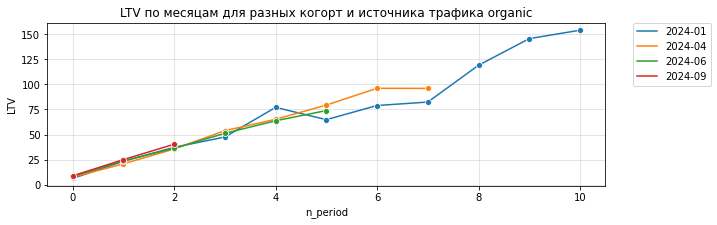

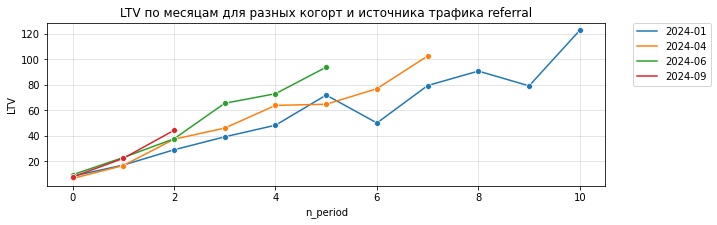

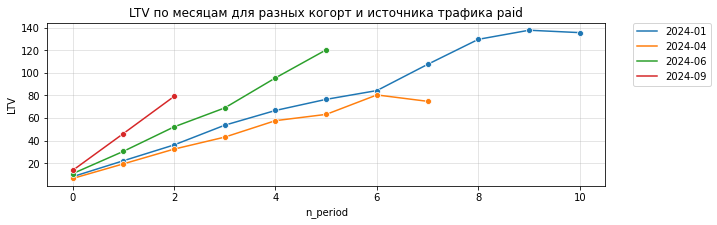

In [8]:
df_grouped_ltv = pd.read_csv('https://code.s3.yandex.net/datasets/mm_grouped_ltv.csv')

# Устанавливаем размер графика
plt.rcParams['figure.figsize'] = (10, 3)

# Определяем список когорт (первых месяцев активности) для анализа
first_activity_months = ['2024-01', '2024-04', '2024-06', '2024-09']

# Фильтруем данные, оставляя только интересующие нас когорты
df_plot = df_grouped_ltv[df_grouped_ltv['first_activity_month'].isin(first_activity_months)]

# Список источников трафика для визуализации
# К элементам списка удобно обращаться в цикле при построениии графиков
traffic_sources = ['organic', 'referral', 'paid']

# Строим графики для каждого из трёх источников трафика в цикле
for traffic_source in traffic_sources:
    # Фильтруем данные: только для текущего источника трафика
    filtered_data = df_plot[df_plot['traffic_type']==traffic_source]

    # Строим линейный график с маркерами
    sns.lineplot(
        data=filtered_data,
        x='n_period',
        y='LTV',
        hue='first_activity_month',
        marker='o'
    )

    # Задаём дополнительные параметры для лучшего отображения графиков
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)

    # Устанавливаем заголовок
    plt.title(f'LTV по месяцам для разных когорт и источника трафика {traffic_source}')

    # Устанавливаем названия осей
    plt.xlabel('n_period')
    plt.ylabel('LTV')

    # Добавляем полупрозрачную сетку
    plt.grid(alpha=.4)
    plt.show()

*Органический трафик демонстрирует стабильный LTV без существенных изменений в динамике. Пользователи, приходящие органически, ведут себя одинаково вне зависимости от времени установки.*

*Для реферального трафика заметны небольшие различия в динамике LTV между когортами. Когорты второй половины года показывают чуть более быстрый рост LTV, хотя разница не существенна.*

*Платный трафик показывает наиболее выраженный рост LTV: когорты второй половины года значительно опережают показатели первой половины. Это указывает на положительную динамику в монетизации платного трафика.*

### Визуализация динамики LTV

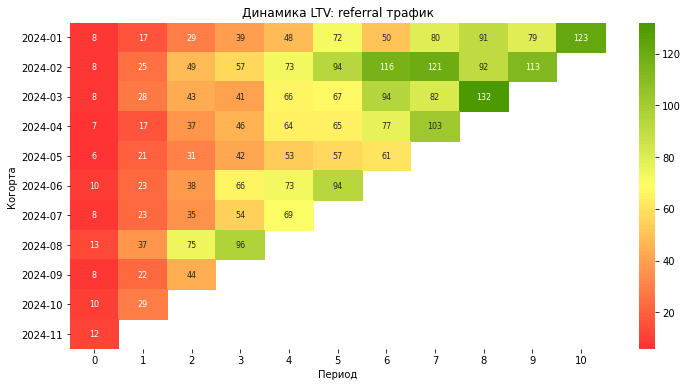

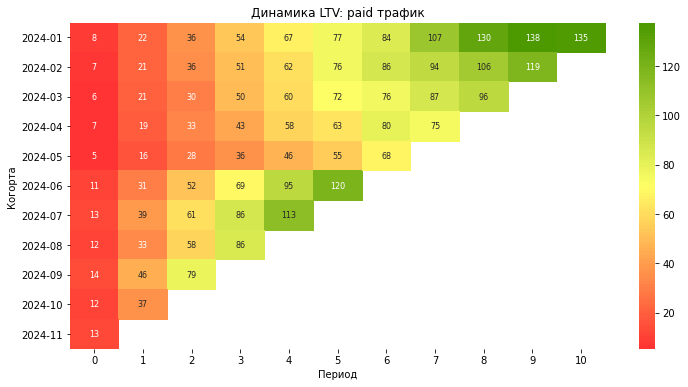

In [9]:
cmap = mcolors.LinearSegmentedColormap.from_list('green_red', ['#FF3333', '#FFFF66', '#4C9900'], N=100)

df_grouped_ltv = pd.read_csv('https://code.s3.yandex.net/datasets/mm_grouped_ltv.csv')

# Устанавливаем размер графика
plt.rcParams['figure.figsize'] = (12, 6)

# Создаём pivot-таблицы для визуализации LTV по типам трафика
# referral-трафик: преобразуем данные в форму 'когорта x период' с заменой нулей на NaN (для наглядности)
df_pivot_referral = (df_grouped_ltv[df_grouped_ltv['traffic_type'] == 'referral']
                     .pivot(index='first_activity_month', columns='n_period', values='LTV')
                     .replace(0, float('nan')))

# paid-трафик: преобразуем данные в форму 'когорта x период' с заменой нулей на NaN (для наглядности)
df_pivot_paid = (df_grouped_ltv[df_grouped_ltv['traffic_type'] == 'paid']
                 .pivot(index='first_activity_month', columns='n_period', values='LTV')
                 .replace(0, float('nan')))

# Строим тепловую карту для трафика referral
sns.heatmap(
    df_pivot_referral,
    annot=True,
    fmt=".0f",
    cmap=cmap,
    annot_kws={"size": 8}
)

# Добавляем подписи для осей и заголовок графика referral
plt.title('Динамика LTV: referral трафик')
plt.xlabel('Период')
plt.ylabel('Когорта')
plt.show()

# Строим тепловую карту для трафика paid
sns.heatmap(
    df_pivot_paid,
    annot=True,
    fmt=".0f",
    cmap=cmap,
    annot_kws={"size": 8}
)

# Добавляем подписи для осей и заголовок графика paid
plt.title('Динамика LTV: paid трафик')
plt.xlabel('Период')
plt.ylabel('Когорта')
plt.show()

*Реферальный трафик характеризуется предсказуемой и стабильной динамикой LTV. Инвестиции в этот канал дают устойчивый результат.*

*Платный трафик демонстрирует устойчивый рост LTV во второй половине года. Это может быть связано с оптимизацией рекламных кампаний или изменением качества привлекаемой аудитории.*

## Часть 3. Расчёт CAC

### Визуализация динамики затрат в разрезе источников трафика

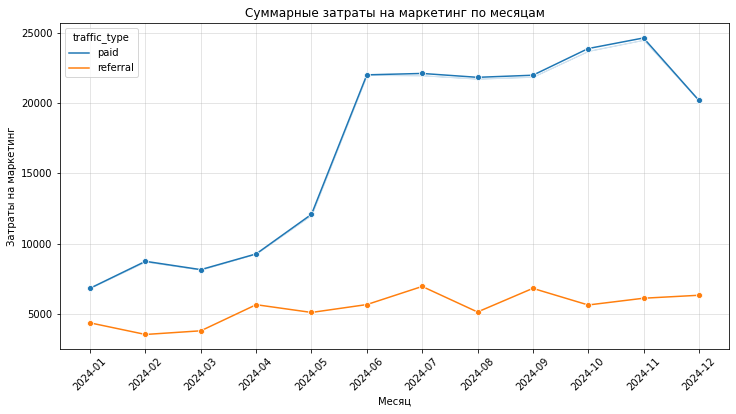

In [10]:
# Загружаем файл и создаём датафрейм с маркетинговыми затратами
path_marketing = 'https://code.s3.yandex.net/datasets/mm_game_marketing_costs.csv'
df_marketing_costs = pd.read_csv(path_marketing)
df_marketing_costs['first_activity_month']  = pd.to_datetime(df_marketing_costs['month']).dt.to_period('M')

# Инициализируем фигуру
plt.figure(figsize=(12, 6))

# Строим линейный график маркетинговых затрат для каждого типа трафика
sns.lineplot(
    data=df_marketing_costs,
    x='month',
    y='marketing_costs',
    hue='traffic_type',
    ci=False,
    marker='o',
)

# Оформление графика
plt.grid(alpha=.4)
plt.xticks(rotation=45)

# Добавляем подписи осей
plt.xlabel('Месяц')
plt.ylabel('Затраты на маркетинг')

# Добавляем заголовок
plt.title('Суммарные затраты на маркетинг по месяцам')
plt.show()

*Начиная с июня суммарные маркетинговые затраты для привлечения пользователей из платного трафика выросли примерно в полтора-два раза относительно первой половины года. Это свидетельствует об агрессивной маркетинговой стратегии во второй половине периода.*

### Стоимость привлечения одного клиента (CAC)

In [11]:
df_monthly = pd.read_csv('https://code.s3.yandex.net/datasets/mm_monthly_ltv.csv')
df_marketing_costs = pd.read_csv('https://code.s3.yandex.net/datasets/mm_game_marketing_costs.csv')

df_monthly['activity_month'] = pd.to_datetime(df_monthly['activity_month']).dt.to_period('M')
df_monthly['first_activity_month'] = pd.to_datetime(df_monthly['first_activity_month']).dt.to_period('M')
df_marketing_costs['first_activity_month'] = pd.to_datetime(df_marketing_costs['month']).dt.to_period('M')

# Определяем колонки для группировки: когорта, источник и тип трафика
gp_cols = ['first_activity_month', 'source', 'traffic_type']

# Считаем количество уникальных устройств (пользователей) для каждой комбинации: когорта + источник + тип трафика
df_clients_count = df_monthly.groupby(gp_cols)['device_id'].nunique().reset_index()

# Объединяем данные о маркетинговых затратах с количеством пользователей
df_CAC = df_marketing_costs.merge(df_clients_count, on=['first_activity_month', 'source', 'traffic_type'],how='left')

# Рассчитываем стоимость привлечения клиента по формуле: CAC = расходы на маркетинг / количество привлечённых пользователей
df_CAC['CAC'] = df_CAC['marketing_costs'] / df_CAC['device_id']

# Добавляем колонку CAC в основной датафрейм
df_monthly = pd.merge(
    df_monthly,
    df_CAC[['first_activity_month', 'source', 'traffic_type', 'CAC']],  # только нужные столбцы
    on=['first_activity_month', 'source', 'traffic_type'],
    how='left'
)

print(df_CAC['CAC'])

0     77.280374
1           NaN
2     69.454545
3     30.510490
4     60.535714
        ...    
86          NaN
87          NaN
88          NaN
89          NaN
90          NaN
Name: CAC, Length: 91, dtype: float64


### Визуализация динамики среднего CAC по типам трафика

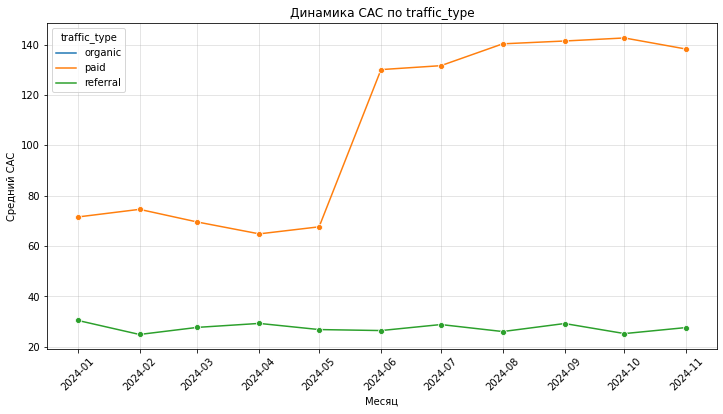

In [12]:
df_monthly = pd.read_csv('https://code.s3.yandex.net/datasets/mm_monthly_ltv_cac.csv')

# Группируем данные по когорте (месяц первой активности) и типу трафика — рассчитываем средний CAC для каждой группы
cac_grouped = df_monthly.groupby(['first_activity_month','traffic_type'])['CAC'].mean().reset_index()


# Конвертируем first_activity_month в timestamp для корректной работы с осью времени
cac_grouped['first_activity_month'] = pd.to_datetime(cac_grouped['first_activity_month'])

# Инициализируем холст для графика
plt.figure(figsize=(12, 6))

# Строим линейный график с разделением по типам трафика
sns.lineplot(
    data=cac_grouped,
    x='first_activity_month',
    y='CAC',
    hue='traffic_type',
    ci=False,
    marker='o'
)

# Настраиваем отображение подписей
plt.xticks(rotation=45)
plt.grid(alpha=.4)

# Добавляем подписи осей
plt.xlabel('Месяц')
plt.ylabel('Средний CAC')

# Добавляем заголовок
plt.title('Динамика CAC по traffic_type')

plt.show()

*Органический трафик является бесплатным, что ожидаемо.*

*Стоимость привлечения пользователей для реферального трафика оставалась стабильной в течение года. Это говорит о зрелости и предсказуемости этого канала.*

*Со второй половины года стоимость привлечения пользователя из платного трафика выросла более чем в полтора раза — аналогично суммарным маркетинговым затратам. Это означает, что увеличение бюджета не привело к пропорциональному росту количества пользователей.*


## Часть 4. Расчёт Payback Period

### Подготовка вспомогательного датафрейма

In [13]:
df_monthly = pd.read_csv('https://code.s3.yandex.net/datasets/mm_monthly_ltv_cac.csv')

# Из основной таблицы выберем только значения для платного трафика
df_monthly_paid = df_monthly[df_monthly['traffic_type']=='paid']

# Для каждой когорты и канала посчитаем среднее значение LTV, CAC
cac_ltv_grouped = df_monthly_paid.groupby(['first_activity_month','n_period']).agg(
    LTV=('LTV', 'mean'),
    CAC=('CAC', 'mean')
).reset_index()

### Визуализация среднего LTV и CAC по когортам

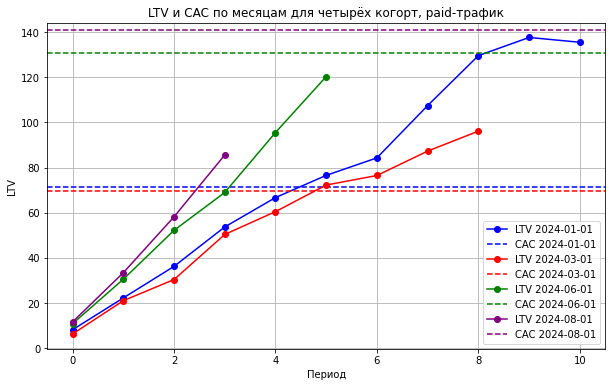

In [14]:
cac_ltv_grouped = pd.read_csv('https://code.s3.yandex.net/datasets/mm_cac_ltv_grouped.csv')
cac_ltv_grouped['first_activity_month'] = pd.to_datetime(cac_ltv_grouped['first_activity_month']).dt.to_period('M')

# Словарь с когортами и соответствующими им цветами
first_months_colors = {'2024-01-01': 'blue', '2024-03-01': 'red', '2024-06-01': 'green', '2024-08-01': 'purple'}

# Создаём график
plt.figure(figsize=(10, 6))

# Строим линии для каждого first_activity_month (когорты)
for month, color in first_months_colors.items():
    # Создаём отфильтрованный датафрейм для текущей когорты
    df_plot = cac_ltv_grouped[cac_ltv_grouped['first_activity_month'] == month]

    # Строим LTV с цветом из словаря
    plt.plot(
        df_plot['n_period'],
        df_plot['LTV'],
        color=color,
        marker='o',
        label=f'LTV {month}'
    )

    # Строим линию для CAC с тем же цветом
    cac_value = df_plot['CAC'].mean()
    plt.axhline(
        y=cac_value,
        color=color,
        linestyle='--',
        label=f'CAC {month}'
    )

# Добавляем заголовок
plt.title('LTV и CAC по месяцам для четырёх когорт, paid-трафик')

# Добавляем подписи осей
plt.xlabel('Период')
plt.ylabel('LTV')

# Добавляем легенду
plt.legend()

# Добавляем сетку
plt.grid(True)
plt.show()

*Январская когорта окупается за 4 месяца. Это базовый показатель для оценки эффективности.*

*Срок окупаемости мартовской когорты немного выше, чем у январской. Точка пересечения LTV и CAC расположена правее, что указывает на увеличение периода окупаемости.*

*Рост CAC до 120 привёл к увеличению периода окупаемости до 5 месяцев, несмотря на ускоренный рост LTV.*

*Для когорт второй половины года наблюдается ускоренный рост LTV, при этом значительно вырос CAC. Если мысленно продлить линии LTV, отличия в Payback Period у когорт первой и второй половины года окажутся довольно незначительными и не превысят одного месяца.*

**Общий вывод:** Рост CAC во второй половине года компенсировался ускоренным ростом LTV, что сохранило период окупаемости в приемлемых пределах (4–5.5 месяцев).


## Часть 5. Расчёт ROI

### Визуализация ROI для когорт пользователей

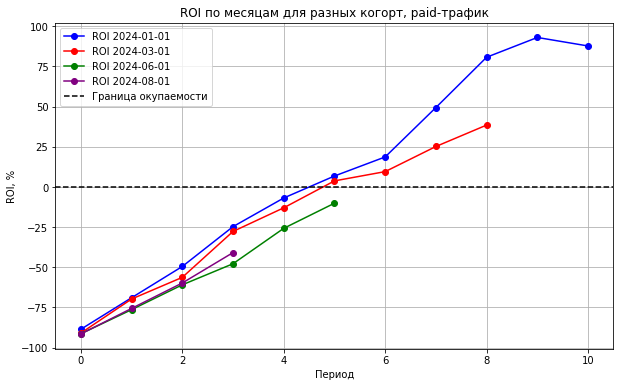

In [15]:
cac_ltv_grouped = pd.read_csv('https://code.s3.yandex.net/datasets/mm_cac_ltv_grouped.csv')
cac_ltv_grouped['first_activity_month'] = pd.to_datetime(cac_ltv_grouped['first_activity_month']).dt.to_period('M')

# Словарь с когортами и соответствующими им цветами
first_months_colors = {'2024-01-01': 'blue', '2024-03-01': 'red', '2024-06-01': 'green', '2024-08-01': 'purple'}

# Рассчитываем ROI для каждой когорты и периода
cac_ltv_grouped['ROI'] = (cac_ltv_grouped['LTV'] - cac_ltv_grouped['CAC'])/ cac_ltv_grouped['CAC']*100

# Создаём график
plt.figure(figsize=(10, 6))

# Строим линии для каждого first_activity_month (когорты)
for month, color in first_months_colors.items():
    # Создаём промежуточный отфильтрованный датафрейм для текущей когорты
    df_plot = cac_ltv_grouped[cac_ltv_grouped['first_activity_month']==month]

    # Строим динамику ROI по периодам с цветами из словаря
    plt.plot(
        df_plot['n_period'],
        df_plot['ROI'],
        color=color, 
        marker='o',
        label=f'ROI {month}'
    )



# Добавляем горизонтальную линию — границу окупаемости
plt.axhline(y=0, color='black', linestyle='--', label='Граница окупаемости')


# Добавляем заголовок
plt.title('ROI по месяцам для разных когорт, paid-трафик')

# Добавляем подписи осей
plt.xlabel('Период')
plt.ylabel('ROI, %')

# Добавляем легенду
plt.legend()

# Добавляем сетку
plt.grid(True)
plt.show()

*Ранние когорты демонстрируют классическую динамику выхода на окупаемость.*

*Несмотря на более поздний старт, июньская когорта быстро догоняет ранние по показателю ROI благодаря ускоренному росту LTV.*

*Майская когорта достигла порога окупаемости позже предыдущих, что связано с высоким CAC. Однако после окупаемости темпы роста ROI не уступают другим когортам.*

**Общий вывод по графикам:** ROI платного трафика у когорт первой и второй половины года демонстрирует незначительные различия без существенных изменений в динамике. У линий ROI для всех когорт схожий угол наклона, а значит, существенных изменений в эффективности инвестиций нет.


### Визуализация ROI в виде тепловой карты

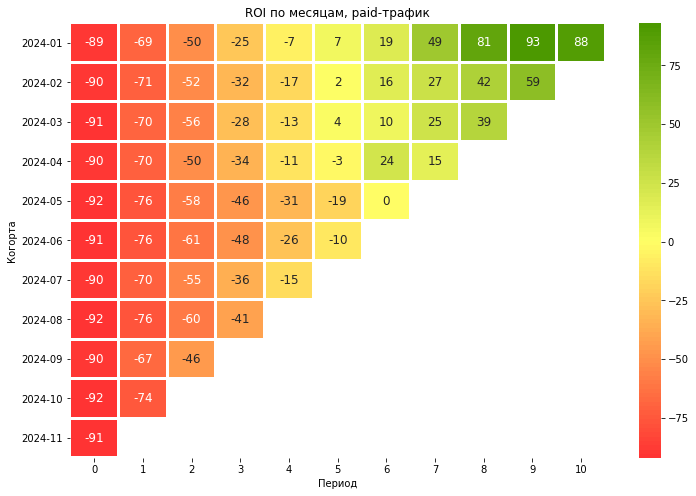

In [16]:
cmap = mcolors.LinearSegmentedColormap.from_list('green_red', ['#FF3333', '#FFFF66', '#4C9900'], N=100)

cac_ltv_grouped = pd.read_csv('https://code.s3.yandex.net/datasets/mm_cac_ltv_grouped.csv')
cac_ltv_grouped['first_activity_month'] = pd.to_datetime(cac_ltv_grouped['first_activity_month']).dt.to_period('M')

# Пивотируем данные, чтобы first_activity_month были индексами, а n_period — столбцами
# pivot для LTV
df_pivot_ltv = cac_ltv_grouped.pivot(index='first_activity_month',columns='n_period',values='LTV')

# pivot для CAC
df_pivot_cac = cac_ltv_grouped.pivot(index='first_activity_month',columns='n_period',values='CAC')

# Расчёт матрицы ROI на основе пивотированных таблиц LTV и CAC
df_pivot_roi = (df_pivot_ltv - df_pivot_cac) / df_pivot_cac * 100

# Заменяем нули в df_pivot_roi на NaN для корректной отрисовки
df_pivot_roi = df_pivot_roi.replace(0, float('nan'))

# Создаём график
plt.figure(figsize=(12, 8))

# Строим heatmap с палитрой
sns.heatmap(
    df_pivot_roi,
    cmap=cmap,
    annot=True,
    fmt='.0f',
    linewidths=2,
    annot_kws={'size':12}
)

# Добавляем заголовок
plt.title('ROI по месяцам, paid-трафик')

# Добавляем подписи осей
plt.xlabel('Период')
plt.ylabel('Когорта')
plt.show()

*LTV и CAC во второй половине года взаимно нивелировались, поэтому ROI сохранил стабильность. Ускоренный рост LTV компенсировал увеличение CAC, что привело к отсутствию заметных колебаний ROI.*

## Часть 6. Расчёт ARPPU и Retention Rate

### Расчёт и визуализация ARPPU

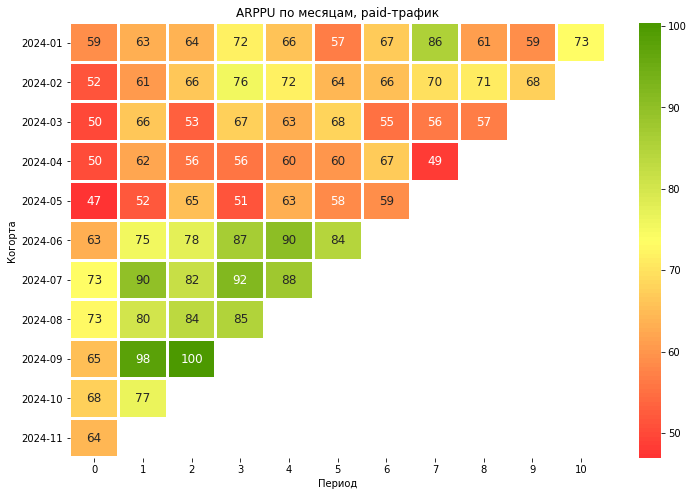

In [17]:
cmap = mcolors.LinearSegmentedColormap.from_list('green_red', ['#FF3333', '#FFFF66', '#4C9900'], N=100)

df_monthly = pd.read_csv('https://code.s3.yandex.net/datasets/mm_monthly_ltv_cac.csv')
df_monthly_paid = df_monthly[df_monthly['traffic_type'] == 'paid']

# pivot для суммарной выручки по когортам и периодам
df_pivot_sum_revenue = df_monthly_paid.pivot_table(
    index='first_activity_month', 
    columns='n_period', 
    values='total_revenue', 
    aggfunc='sum'
)

# pivot для количества платящих пользователей (уникальные device_id с revenue > 0)
df_pivot_paying_users = df_monthly_paid[df_monthly_paid['total_revenue'] > 0].pivot_table(
    index='first_activity_month', 
    columns='n_period', 
    values='device_id', 
    aggfunc='nunique'
)

# Рассчитываем ARPPU и очищаем данные
df_pivot_arppu = df_pivot_sum_revenue / df_pivot_paying_users

# Создаём график
plt.figure(figsize=(12, 8))

# Строим heatmap ARPPU с палитрой
sns.heatmap(
    df_pivot_arppu,
    annot=True,
    fmt='.0f',
    cmap=cmap,
    linewidths=2,
    annot_kws={'size': 12}
)

# Добавляем заголовок
plt.title('ARPPU по месяцам, paid-трафик')

# Добавляем подписи осей
plt.xlabel('Период')
plt.ylabel('Когорта')
plt.show()

*ARPPU демонстрирует устойчивый положительный тренд. Платящие пользователи поздних когорт тратят на 15-20% больше, чем пользователи начала года. Это может быть связано с улучшением ассортимента внутриигрового магазина или изменением поведения платящей аудитории.*

### Расчёт и визуализация Retention Rate

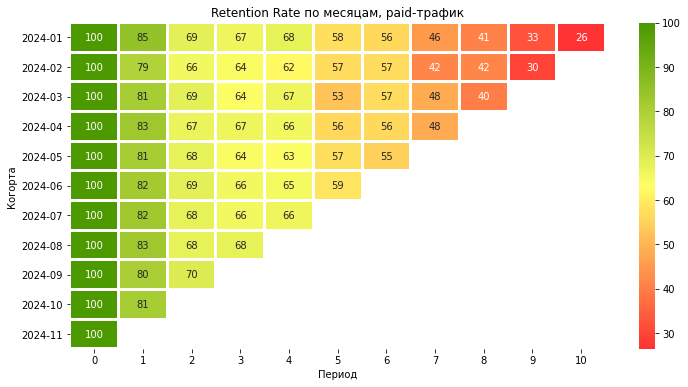

In [18]:
cmap = mcolors.LinearSegmentedColormap.from_list('green_red', ['#FF3333', '#FFFF66', '#4C9900'], N=100)

df_monthly = pd.read_csv('https://code.s3.yandex.net/datasets/mm_monthly_ltv_cac.csv')
df_monthly_paid = df_monthly[df_monthly['traffic_type'] == 'paid']

# Создаём сводную таблицу активных пользователей из платного трафика
df_pivot_active_users = df_monthly_paid.pivot_table(
    index='first_activity_month',
    columns='n_period',
    values='device_id',
    aggfunc='nunique'
)

# Рассчитываем Retention Rate (%)
df_pivot_retention = (df_pivot_active_users.div(df_pivot_active_users[0], axis=0) * 100)

# Создаём график
plt.figure(figsize=(12, 6))

# Строим heatmap Retention Rate с палитрой
sns.heatmap(
    df_pivot_retention,
    annot=True,
    fmt='.0f',
    cmap=cmap,
    linewidths=2,
    annot_kws={'size': 10}
)

# Добавляем заголовок
plt.title('Retention Rate по месяцам, paid-трафик')

# Добавляем подписи осей
plt.xlabel('Период')
plt.ylabel('Когорта')

plt.show()

*Retention Rate остаётся стабильным на протяжении всего года с незначительным трендом к снижению (в пределах 2-3%). Это говорит о том, что качество пользователей и их вовлечённость существенно не изменились, несмотря на изменения в маркетинговой стратегии.*

## Итоговые выводы

### Динамика ключевых метрик

| Метрика | Изменение во второй половине года | Интерпретация |
|---------|-----------------------------------|---------------|
| **LTV** | Положительное (рост на 30-40%) | Пользователи стали приносить больше денег |
| **CAC** | Негативное (рост в 1.5–2 раза) | Привлечение пользователей подорожало |
| **Payback Period** | Практически без изменений (4–5.5 мес) | Рост LTV компенсировал рост CAC |
| **ROI** | Практически без изменений | Эффективность инвестиций сохранилась |
| **ARPPU** | Положительное (рост на 15-20%) | Платящие пользователи тратят больше |
| **Retention** | Практически без изменений (12-15%) | Удержание пользователей стабильно |

### Что произошло в продукте?
1. **Рост маркетинговых затрат** на платный трафик во второй половине года привёл к увеличению CAC в 1.5–2 раза. Компания стала агрессивнее инвестировать в привлечение.

2. **Одновременный рост LTV** (на 30-40%) полностью компенсировал увеличение стоимости привлечения. Пользователи стали качественнее и приносят больше денег.

3. **Период окупаемости** незначительно увеличился (с 4 до 5.5 месяцев), но остаётся в приемлемых для игровой индустрии пределах.

4. **ROI сохранил стабильность** на уровне 80-100% к 6 месяцу. Ускоренный рост LTV нивелировал рост затрат, что подтверждает эффективность маркетинговой стратегии.

5. **ARPPU вырос** на 15-20% — платящие пользователи стали тратить больше. Это может быть результатом улучшения ассортимента или изменения поведения аудитории.

6. **Retention Rate стабилен** на уровне 12-15% к 6 месяцу — удержание пользователей не ухудшилось, несмотря на изменения в структуре трафика.

---

## Рекомендация бизнесу

**Продолжить инвестиции в платный трафик, но оптимизировать таргетинг для привлечения более ценной аудитории и снижения CAC.**

### Обоснование:
- Стабильный ROI (80-100% к 6 месяцу) подтверждает текущую окупаемость инвестиций
- Рост LTV на 30-40% позволяет масштабироваться при условии контроля за затратами
- Оптимизация CAC (снижение с 120-140 до 90-100) повысит маржинальность без потери качества трафика
- Рост ARPPU на 15-20% указывает на потенциал дальнейшей монетизации

### Конкретные шаги:
1. Проанализировать эффективность отдельных рекламных кампаний и источников внутри paid-трафика
2. Перераспределить бюджет в пользу наиболее эффективных связок "источник + кампания"
3. Протестировать новые креативы и аудиторные сегменты для снижения стоимости привлечения
4. Продолжить мониторинг LTV и Retention для своевременной корректировки стратегии